In [7]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [422]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

## Data

In [66]:
from data import load
inputs, outputs, reference = load('bec1d.data')

In [428]:
torch.randint(0, N, ())

tensor(17418)

In [431]:
def transform_data_for_gp(datafile='bec1d.data', num_samples=None):
    inputs, outputs, reference = load(datafile)
    N = len(inputs)
    M = num_samples if num_samples else N
    assert N == 50000
    x_size = len(reference['x'])
    assert x_size == 512
    g = torch.tensor(inputs).float()
    x = torch.tensor(reference['x']).float()
    y = torch.tensor(outputs).float()
    gx = torch.stack(
        [g.view(1, -1).repeat(x_size, 1).t(), x.repeat(N, 1)]
    ).permute(1, 0, 2)
    gxy = torch.cat([gx, y.view(N, 1, -1)], dim=1)
    gxy_tensor_short = gxy.permute(1, 0, 2)[:M].contiguous().view(3, -1).t()
    gx_samples = gxy_tensor_short[torch.randint(0, gxy_tensor_short.size(0), (M,))]
    X = gx_samples[:, :2]
    y = gx_samples[:, -1]
    assert X.size() == (M, 2)
    assert y.size() == (M, )
    
    x_pred = x
    # g_pred = g[torch.randint(0, x_size, ())].repeat(x_size)

    return (X, y), (x_pred, g)


(X, y), (x_pred, g) = transform_data_for_gp(num_samples=100)

## 2D Gaussian Process

In [445]:
X.shape[-1], y.shape[-1]

(2, 100)

In [443]:
kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp.fit(X.data.numpy(), y.data.numpy())

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.76547105e-04, -2.91925803e+01, -2.23549099e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 11, 'warnflag': 2}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=[5, 5]),
             n_restarts_optimizer=15, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

## Helpers

In [423]:
def to_np(t): return t.data.numpy()
def to_to(a): return torch.tensor(a).float()

In [435]:
def prepare_prediction_data(datafile='bec1d.data', ):
    g_pred = 
    g_pred = g_pred.repeat(len(x_pred))
    gx_pred = torch.stack([g_pred, to_to(x_pred)])
    assert to_np(gx_pred).shape == (2, 512)
    
prepare_prediction_data(X, g, x_pred)

## Prediction with Uncertainty Estimates

In [448]:
def predict(x, *args, **kwargs):
    y_hat_pred, sigma = gp.predict(to_np(x).transpose(), *args, **kwargs)
    
predict(gx_pred, return_std=True)

In [446]:
y_hat_pred, sigma = gp.predict(to_np(gx_pred).transpose(), return_std=True)

In [449]:
to_np(gx_pred).transpose().shape

(512, 2)

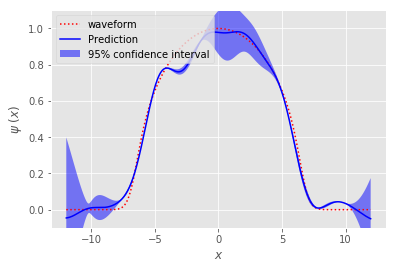

In [477]:
def plot_gp_prediction(x_pred, y_pred, y_pred_gp):
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure()
    plt.plot(x_pred, y_pred, 'r:', label='waveform')

    # plt.plot(x_pred, y_pred, 'r.', markersize=10, label='Observations')
    plt.plot(x_pred, y_pred_gp, 'b-', label='Prediction')

    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
             np.concatenate([y_pred_gp - 1.9600 * sigma,
                            (y_pred_gp + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    
    plt.xlabel('$x$')
    plt.ylabel('$\psi\ (x)$')
    plt.ylim(-0.1, 1.1)
    plt.legend(loc='upper left')
    
plot_gp_prediction(dldr.x, dldr.pred_y, gp.predict(dldr.pred_gx))

In [480]:
from gp_bec import DataLoader, plot_gp_prediction

In [481]:
dldr = DataLoader()

In [499]:
trainX, trainY = dldr.prepare_train_data(1000)
gp.fit(trainX, trainY)

KeyboardInterrupt: 

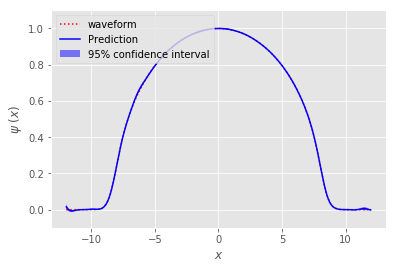

In [502]:
predX, predgX, predY = dldr.prepare_prediction_data(19995)
y_pred_gp, sigma = gp.predict(predgX, return_std=True)
plot_gp_prediction(dldr.x, predY, y_pred_gp, sigma)